In [320]:
import sys
sys.path.append('../../workbooks/')
import scalebar

import matplotlib.pyplot as plt
import seaborn as sns 


import ulmo
import calendar

import pandas as pd
from pandas.io.json import json_normalize

import matplotlib as pyplot
from matplotlib import colors
from matplotlib.transforms import Bbox


import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib import patches

import rasterio as rio
from rasterio import plot
from rasterio.plot import show

from datetime import timedelta

import json



from matplotlib import lines



import numpy as np

%matplotlib inline

In [328]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])
    return bbox.expanded(1.0 + pad, 1.0 + pad)

def add_backbox(fig, axes, color, pad=0):
    extent = Bbox.union([full_extent(ax, pad=pad) for ax in axes])
    extent = extent.transformed(fig.transFigure.inverted())

    # We can now make the rectangle in figure coords using the "transform" kwarg.
    rect = patches.Rectangle([extent.xmin, extent.ymin], extent.width, extent.height,
                     facecolor=color, edgecolor='none', zorder=-1, alpha=0.3 ,
                     transform=fig.transFigure)
    fig.patches.append(rect)





# Study Sites Climatological Comparisons


In [123]:
DANA_ELEVATION = 2987 # meters
LOST_TRAIL_ELEVATION = 2804 #meters

## Tuolumne

In [124]:
dana_snotel = pd.read_csv("TUM-DAN_Pillow_SWE.csv", parse_dates=[0]).rename({
    "Date [yyyy-mm-dd]": "Date",
    " Dana Meadows Pillow SWE [mm]" : "DanaSWE"
}, axis=1).drop(" Tuolumne Meadows Pillow SWE [mm]", axis=1)

dana_snotel.DanaSWE = pd.to_numeric(dana_snotel.DanaSWE.str.strip(), errors='coerce') / 10 # convert to cm
# dana_snotel.loc[dana_snotel.VALUE == '---', 'VALUE']= pd.np.nan
# dana_snotel.VALUE = pd.to_numeric(dana_snotel.VALUE)

In [125]:
dana_snotel.columns

Index(['Date', 'DanaSWE'], dtype='object')

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


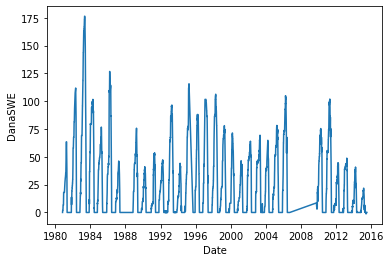

In [126]:
sns.lineplot(x='Date', y='DanaSWE', data=dana_snotel)

In [133]:
def assign_wy(date):
    if not pd.isna(date):
        if date.month>=10:
            return(pd.datetime(date.year+1,1,1).year)
        else:
            return(pd.datetime(date.year,1,1).year)
    else: 
        return pd.NaT
    


In [134]:
dana_snotel['Date'].min().year

1980

In [135]:
dana_snotel['WY'] = dana_snotel['Date'].apply(assign_wy)

In [136]:
dana_snotel = dana_snotel.dropna(axis=0, subset=['DanaSWE'])

In [137]:
dana_snotel['Date'].min().year

1980

In [138]:
wyd = dana_snotel.groupby("WY").apply(lambda g: g.reset_index())

In [139]:
dana_snotel['wyd'] = dana_snotel.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

In [140]:
def wyd_to_doy(wyd):
    if(wyd > 366): return np.nan
    doy = pd.datetime(1999, 10, 1) + timedelta(days=wyd)
    return"{} {}".format(calendar.month_abbr[doy.month], doy.day)

In [141]:
def format_doy(value, tick_number):
    # find number of multiples of pi/2
    return(wyd_to_doy(value))



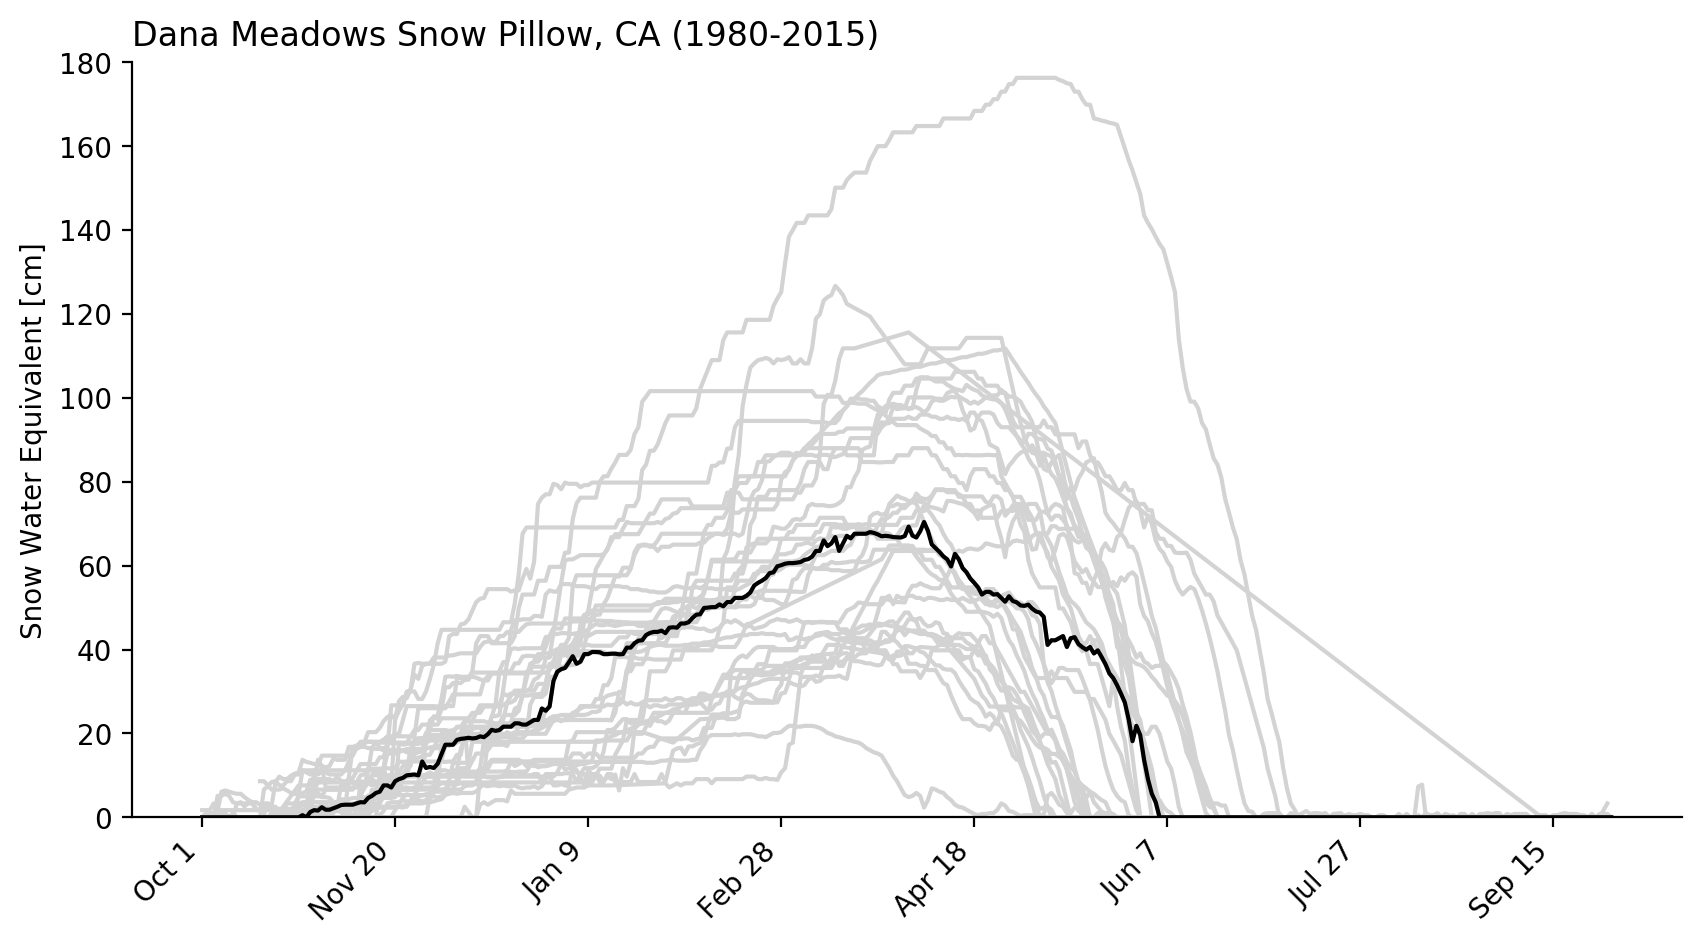

In [142]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

for group in dana_snotel.groupby("WY"):
    ax.plot(group[1].groupby("wyd").median().index.days, group[1].groupby("wyd").median().DanaSWE.values, color='lightgray')
    
study_year = dana_snotel[dana_snotel.WY == 2018]
ax.plot(study_year.groupby('wyd').median().index.days, study_year.groupby('wyd').median().DanaSWE.values, color='red')
    
ax.plot(dana_snotel.groupby("wyd").median().index.days, dana_snotel.groupby("wyd").median()['DanaSWE'].values, color='black')
locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_ylim([0, 180])
ax.set_ylabel("Snow Water Equivalent [cm]")
minyear = dana_snotel['Date'].min().year
maxyear = dana_snotel['Date'].max().year
ax.set_title("Dana Meadows Snow Pillow, CA ({}-{})".format(minyear, maxyear), loc='left')
sns.despine()

Set minimum number of observations for a given year to be plotted?

## Colorado

In [143]:
co_snotel = pd.read_csv("SNOTEL669_WTEQ.txt", comment='#', parse_dates=[0])

In [144]:
co_snotel.columns

Index(['Date', 'North Lost Trail (669) Snow Water Equivalent (in) Start of Day Values'], dtype='object')

In [145]:
co_snotel = co_snotel.rename({"North Lost Trail (669) Snow Water Equivalent (in) Start of Day Values" : "WTEQ"}, axis=1)

In [146]:
co_snotel

,Date,WTEQ
0,1985-09-18,0.0
1,1985-09-19,0.0
2,1985-09-20,0.0
3,1985-09-21,0.0
4,1985-09-22,0.0
...,...,...
12581,2020-02-28,14.6
12582,2020-02-29,14.7
12583,2020-03-01,14.7
12584,2020-03-02,15.1


In [147]:
# convert to cm
co_snotel.WTEQ = co_snotel.WTEQ * 2.54

In [148]:
co_snotel['WY'] = co_snotel.Date.apply(assign_wy)

In [149]:
co_snotel['wyd'] = co_snotel.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

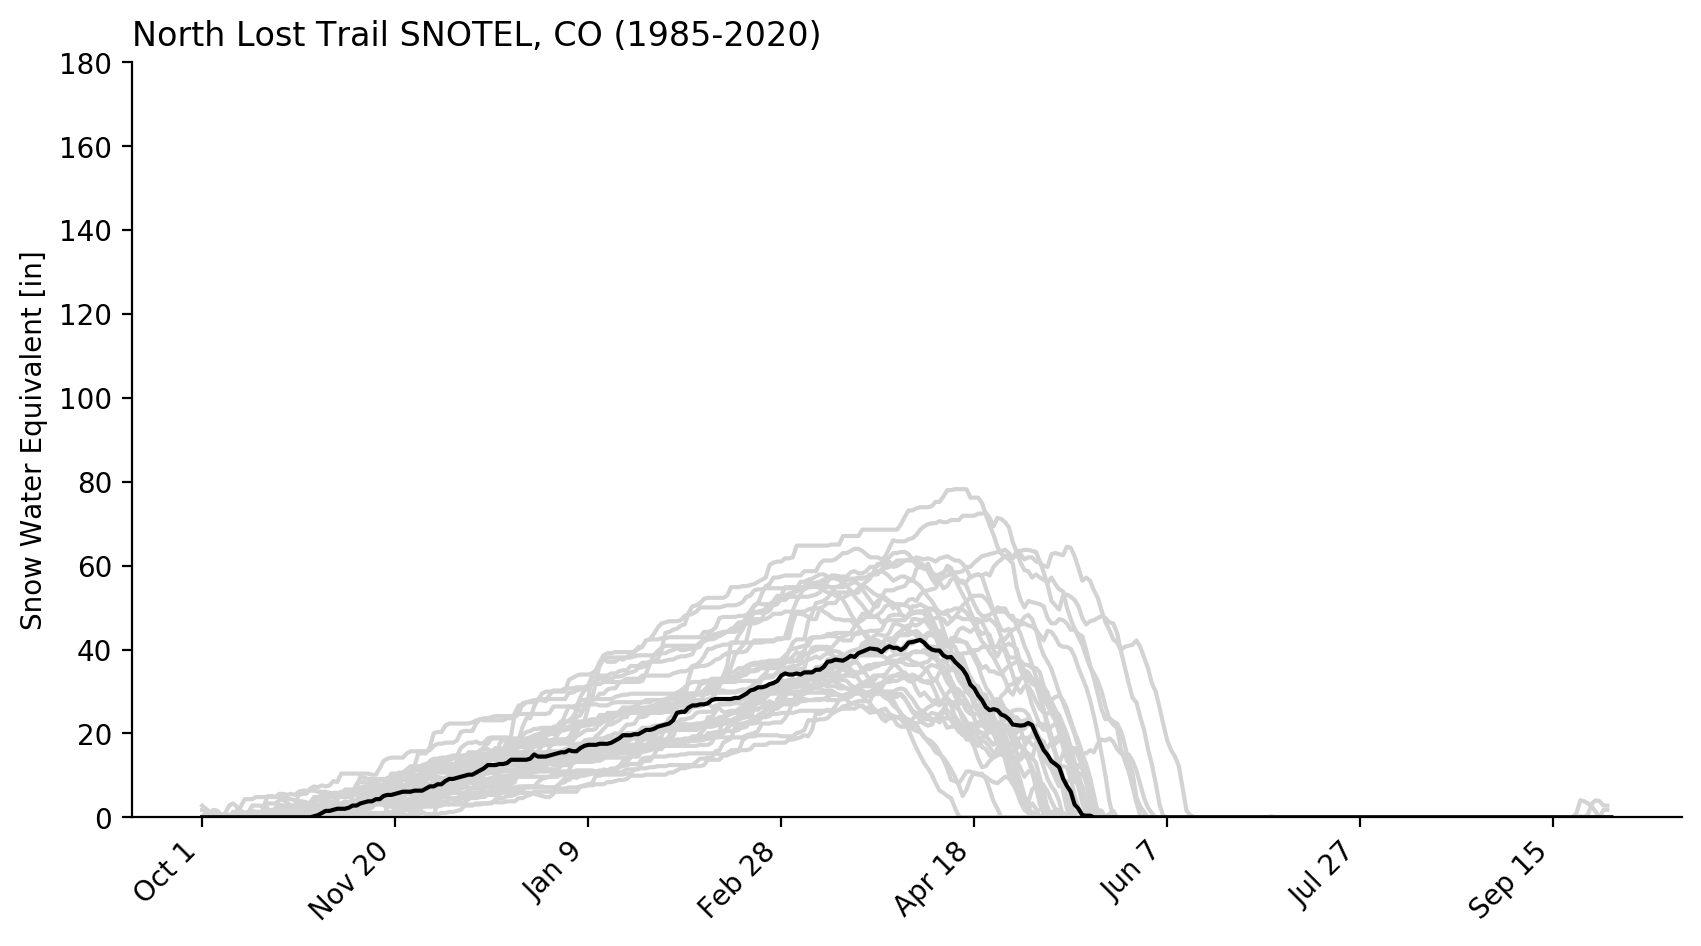

In [150]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
snotel = co_snotel
for group in snotel.groupby("WY"):
    ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").median().WTEQ.values, color='lightgray')
    
ax.plot(snotel.groupby("wyd").mean().index.days, snotel.groupby("wyd").median().WTEQ.values, color='black')
locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
ax.set_ylim([0, 180])
ax.set_ylabel("Snow Water Equivalent [in]")
ax.set_title("North Lost Trail SNOTEL, CO (1985-2020)", loc='left')
sns.despine()

In [294]:
def plot_snow(data, snowcol, title, ax, color = 'black', sharey=False, lighten=0.3):
    for group in data.groupby("WY"):
        ax.plot(group[1].groupby("wyd").mean().index.days, group[1].groupby("wyd").median()[snowcol].values, color=lighten_color(color, amount=lighten))
    
    ax.plot(data.groupby("wyd").mean().index.days, data.groupby("wyd").median()[snowcol].values, color=color)

    locs, labels = plt.xticks()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
#     plt.setp(ax.get_xticklabels(), ha="right", rotation=0)
    ax.set_ylim([0, 180])
    if not sharey:
        ax.set_ylabel("SWE [cm]")
    ax.set_title(title, loc='left')
    sns.despine()

## Both

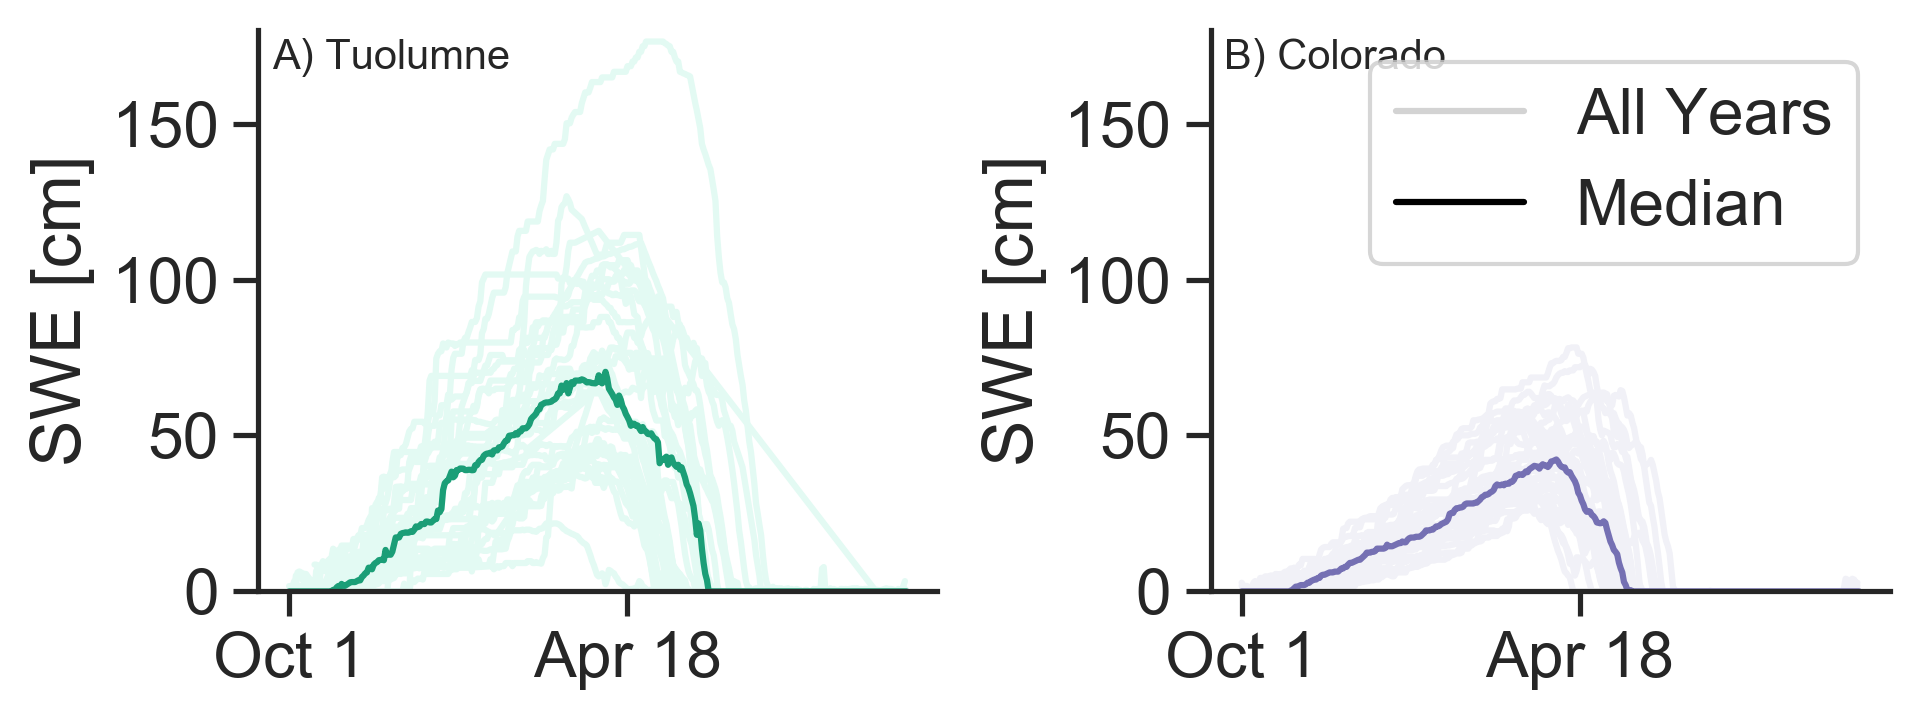

In [290]:
fig, axes = plt.subplots(1, 2, figsize=(6.5,2.5), dpi=300)


dana_minyear = dana_snotel["Date"].min().year
dana_maxyear = dana_snotel["Date"].max().year
# title  =f"Dana Meadows Snow Pillow, CA ({dana_minyear}-{dana_maxyear})"
title=""
plot_snow(dana_snotel, "DanaSWE", title, axes[0], color=CA_color)

co_minyear = co_snotel.Date.min().year
co_maxyear = co_snotel.Date.max().year
# title = f"North Lost Trail SNOTEL, CO ({co_minyear}-{co_maxyear})"
title = ""
plot_snow(co_snotel, 'WTEQ', title, axes[1], color=CO_color)


plt.tight_layout() 

axes[1].legend(handles=[
    lines.Line2D([], [], color='lightgray', label="All Years"),
    lines.Line2D([], [], color='black', label="Median")
], loc='upper right')

axes[0].text(0.02, .93, 'A) Tuolumne', transform=axes[0].transAxes)
axes[1].text(0.02, .93, 'B) Colorado', transform=axes[1].transAxes)
# axes[0].text(0.75, .93, f'{co_minyear}-{co_maxyear}', fontsize=8, color='lightgray', transform=axes[0].transAxes)
# axes[1].text(0.75, .93, f'{dana_minyear}-{dana_maxyear}', fontsize=8, color='lightgray', transform=axes[1].transAxes)


plt.savefig("swe-test.pdf", dpi=300)
plt.savefig("swe-test.png", dpi=300)

## Temp – CA

In [153]:
dana_temp = pd.read_csv("Dana_Meadows_model_forcing_dataset.csv", parse_dates=[1])
dana_temp.columns = dana_temp.columns.str.strip()

In [154]:
dana_temp.head()

,date_time_UTC,date_time_PST,T_deg_C,Wind_m_per_s,RH_percent,SWdwnGapFill,LWdwnMTCLIM,precip_m
0,2002/10/01 07:00:00,2002-09-30 23:00:00,-5.56,0.447,91,0.0,220.74,0.0
1,2002/10/01 08:00:00,2002-10-01 00:00:00,-5.56,0.447,81,0.0,220.74,0.0
2,2002/10/01 09:00:00,2002-10-01 01:00:00,-5.56,0.447,52,0.0,220.74,0.0
3,2002/10/01 10:00:00,2002-10-01 02:00:00,-6.11,0.447,44,0.0,218.94,0.0
4,2002/10/01 11:00:00,2002-10-01 03:00:00,-6.67,0.447,41,0.0,217.14,0.0


In [155]:
# dana_temp = pd.read_csv("Dana_Meadows_model_forcing_dataset.csv")
# dana_temp.loc[dana_temp.VALUE == '---', 'VALUE']= pd.np.nan
# dana_temp = dana_temp.dropna(axis=0, subset=['VALUE'])
# dana_temp.VALUE = pd.to_numeric(dana_temp.VALUE)

In [156]:
dana_temp_daily = dana_temp.set_index('date_time_PST').resample('D', how='mean').reset_index()
dana_pcp_daily = dana_temp.set_index('date_time_PST').resample('D', how='sum').reset_index()

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':
/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from ipykernel import kernelapp as app


In [162]:
dana_temp['WY'] = dana_temp['date_time_PST'].apply(assign_wy)
dana_temp['wyd'] = dana_temp.apply(lambda x: x['date_time_PST'] - pd.datetime(x.WY - 1, 10, 1), axis=1)


In [163]:
dana_temp_daily['WY'] = dana_temp_daily['date_time_PST'].apply(assign_wy)
dana_temp_daily['wyd'] = dana_temp_daily.apply(lambda x: x['date_time_PST'] - pd.datetime(x.WY - 1, 10, 1), axis=1)
dana_pcp_daily['WY'] = dana_pcp_daily['date_time_PST'].apply(assign_wy)
dana_pcp_daily['wyd'] = dana_pcp_daily.apply(lambda x: x['date_time_PST'] - pd.datetime(x.WY - 1, 10, 1), axis=1)


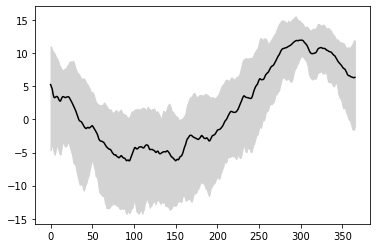

In [164]:
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = dana_temp_daily.groupby("wyd").mean()['T_deg_C'].rolling(10, min_periods=0).mean()
rolling_wy_max = dana_temp_daily.groupby("wyd").max()['T_deg_C'].rolling(10, min_periods=0).mean()
rolling_wy_min = dana_temp_daily.groupby("wyd").min()['T_deg_C'].rolling(10, min_periods=0).mean()
plt.plot(range(0, 366), rolling_wy_mean, color='black')
plt.fill_between(
    range(0, 366),
    rolling_wy_max,
    rolling_wy_min,
color='lightgray')


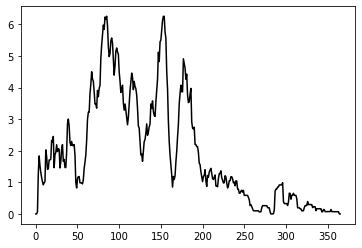

In [169]:
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = dana_pcp_daily.groupby(dana_pcp_daily.wyd).mean()['precip_m'].rolling(10, min_periods=0).mean() * 1000 # CONVERT TO MM
# rolling_wy_max = dana_pcp_daily.groupby("wyd").max()['precip_m'].rolling(10, min_periods=0).mean() * 1000
# rolling_wy_min = dana_pcp_daily.groupby("wyd").min()['precip_m'].rolling(10, min_periods=0).mean() * 1000
plt.plot(range(0, 366), rolling_wy_mean, color='black')
# plt.fill_between(
#     range(0, 366),

#     rolling_wy_max,
#     rolling_wy_min,
# color='lightgray')


## CO



In [171]:
co_tavg = pd.read_csv("SNOTEL669_TAVG.txt", comment='#', parse_dates=['Date'])
co_tavg = co_tavg.rename({"North Lost Trail (669) Air Temperature Average (degF)": "TAVG"}, axis=1)

In [172]:
# convert to C
co_tavg.TAVG = (co_tavg.TAVG - 32) * (5/9)

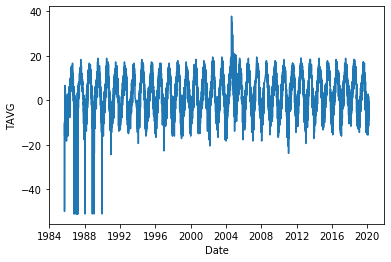

In [173]:
sns.lineplot(x='Date', y='TAVG', data=co_tavg)

In [174]:
co_tavg.loc[co_tavg.TAVG < -40, 'TAVG'] = pd.np.nan
co_tavg = co_tavg.dropna(subset=["TAVG"])

In [175]:
co_tavg.TAVG = co_tavg.TAVG.rolling(10).mean()

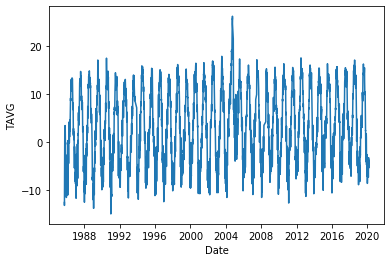

In [176]:
sns.lineplot(x='Date', y='TAVG', data=co_tavg)

In [177]:
co_tavg['WY'] = co_tavg.Date.apply(assign_wy)
co_tavg['wyd'] = co_tavg.apply(lambda x: x.Date - pd.datetime(x.WY - 1, 10, 1), axis=1)


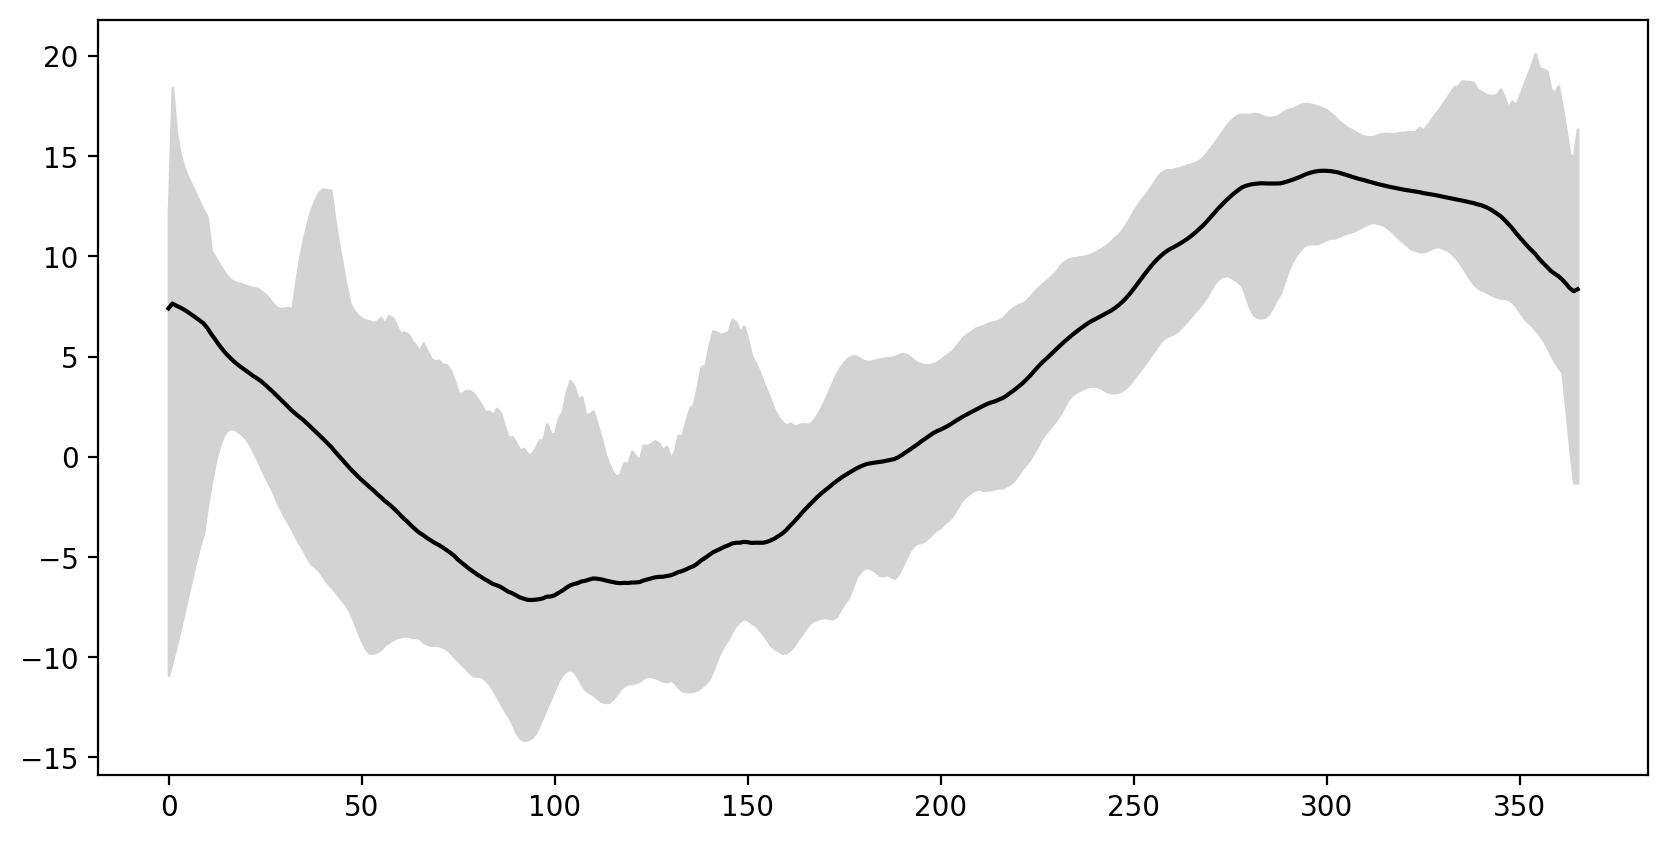

In [178]:
fig = plt.figure(figsize=(10,5), dpi=200)
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = co_tavg.groupby("wyd").mean()['TAVG'].rolling(10, min_periods=1).mean()
rolling_wy_max = co_tavg.groupby("wyd").max()['TAVG'].rolling(10, min_periods=1).mean()
rolling_wy_min = co_tavg.groupby("wyd").min()['TAVG'].rolling(10, min_periods=1).mean()
plt.plot(range(0, 366), rolling_wy_mean, color='black')
plt.fill_between(
    range(0, 366),
    rolling_wy_max,
    rolling_wy_min,
color='lightgray')

### precip

In [179]:
co_precip = pd.read_csv("SNOTEL669_PRECIP.txt", comment='#', parse_dates=['Date']).rename({
    "North Lost Trail (669) Precipitation Increment - Snow-adj (in)" : 'pcp_adjusted',
    "North Lost Trail (669) Precipitation Increment (in)": 'pcp',
    "North Lost Trail (669) Precipitation Accumulation (in) Start of Day Values" : 'pcp_accum'
}, axis=1)

# convert to meters
for col in ["pcp_accum", 'pcp', 'pcp_adjusted']:
    co_precip.loc[co_precip.index, col] = co_precip[col] * 0.0254

In [180]:
co_precip.head()

,Date,pcp_accum,pcp,pcp_adjusted
0,1985-10-01,0.0,0.0,0.0
1,1985-10-02,0.0,0.0,0.0
2,1985-10-03,0.0,0.0,0.0
3,1985-10-04,0.0,0.0,0.0
4,1985-10-05,0.0,0.0,0.0


In [181]:
# co_precip = co_precip.set_index('Date').resample('M', how='sum').reset_index()

In [182]:
co_precip['WY'] = co_precip['Date'].apply(assign_wy)
co_precip['wyd'] = co_precip.apply(lambda x: x['Date'] - pd.datetime(x.WY - 1, 10, 1), axis=1)

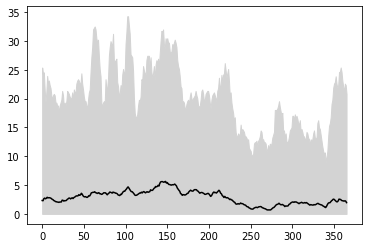

In [183]:
# plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
rolling_wy_mean = co_precip.groupby("wyd").mean()['pcp_adjusted'].rolling(10, min_periods=0).mean() * 1000
rolling_wy_max = co_precip.groupby("wyd").max()['pcp_adjusted'].rolling(10, min_periods=0).mean() * 1000
rolling_wy_min = co_precip.groupby("wyd").min()['pcp_adjusted'].rolling(10, min_periods=0).mean() * 1000
plt.plot(range(0, 366), rolling_wy_mean, color='black')
plt.fill_between(
    range(0, 366),
    rolling_wy_max,
    rolling_wy_min,
color='lightgray')


In [184]:
# fig = plt.figure(figsize=(10,5), dpi=200)

# # plt.plot(dana_temp.groupby("wyd").max().index.days, dana_temp.groupby("wyd").max().mean()['T_deg_C'].values, color='lightgray')
# rolling_wy_mean = co_precip.groupby(co_precip.Date.dt.month).mean()['pcp_adjusted'].rolling(10, min_periods=0).mean() * 1000
# # rolling_wy_max = co_precip.groupby("wyd").max()['pcp_adjusted'].rolling(10, min_periods=0).mean() * 1000
# # rolling_wy_min = co_precip.groupby("wyd").min()['pcp_adjusted'].rolling(10, min_periods=0).mean() * 1000
# plt.bar(range(0,12), rolling_wy_mean, color='black')
# plt.ylabel("Precipitation [mm]")
# # plt.fill_between(
# #     range(0, 366),
# #     rolling_wy_max,
# #     rolling_wy_min,
# # color='lightgray')


## Combine

**Temperature**

In [185]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [186]:
def plot_temp(data, tempcol, ax,color='black', roll=10):
    rolling_wy_mean = data.groupby("wyd").mean()[tempcol].rolling(roll, min_periods=0).mean()
    rolling_wy_max = data.groupby("wyd").max()[tempcol].rolling(roll, min_periods=0).mean()
    rolling_wy_min = data.groupby("wyd").min()[tempcol].rolling(roll, min_periods=0).mean()
    ax.plot(range(0, 366), rolling_wy_mean, color=color)
    ax.fill_between(
        range(0, 366),
        rolling_wy_max,
        rolling_wy_min,
    color=color, alpha=0.1)


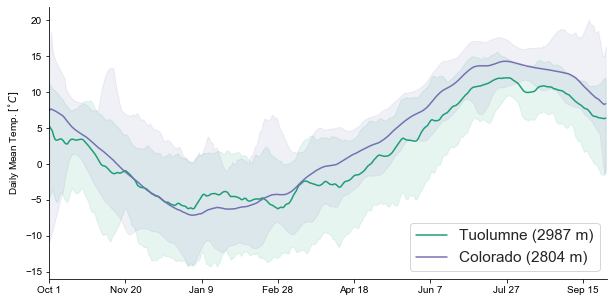

In [187]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="ticks", font_scale=1.4)


CA_color = "#1b9e77"
CO_color = "#7570b3"

plot_temp(dana_temp_daily, 'T_deg_C', ax=ax, color=CA_color)
plot_temp(co_tavg, "TAVG", ax=ax, color=CO_color)

ax.set_xlim([0, 366])

locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))

ax.legend(handles=[
    lines.Line2D([],[], color=CA_color, label=f'Tuolumne ({DANA_ELEVATION} m)')  ,
    lines.Line2D([],[], color=CO_color, label=f'Colorado ({LOST_TRAIL_ELEVATION} m)')
], loc='lower right')

ax.set_ylabel("Daily Mean Temp. $[^{\circ}C]$")

sns.despine()

**Precipitation**

In [188]:
def plot_precip(data, precip_col, ax, color='black', roll=10):
    rolling_wy_mean = data.groupby("wyd").mean()[precip_col].rolling(roll, min_periods=0).mean() * 1000
    ax.plot(range(0, 366), rolling_wy_mean, color=color)



Text(0, 0.5, 'Precip. [mm]')

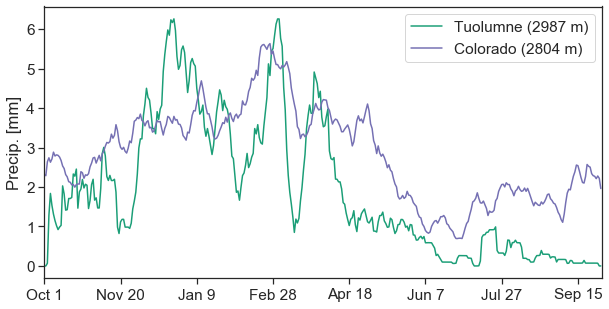

In [189]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style="ticks", font_scale=1.4)


CA_color = "#1b9e77"
CO_color = "#7570b3"

plot_precip(dana_pcp_daily, "precip_m", ax, color=CA_color)
plot_precip(co_precip, 'pcp_adjusted', ax, color=CO_color)


ax.set_xlim([0, 366])

locs, labels = plt.xticks()
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))

ax.legend(handles=[
    lines.Line2D([],[], color=CA_color, label=f'Tuolumne ({DANA_ELEVATION} m)')  ,
    lines.Line2D([],[], color=CO_color, label=f'Colorado ({LOST_TRAIL_ELEVATION} m)')
], loc='upper right')


ax.set_ylabel("Precip. [mm]")


## Locator Maps

In [346]:
CA_color = "#1b9e77"
CO_color = "#7570b3"
CA_bbox = [-124.48200307,-114.13078164,32.52952353,42.00949894]
CO_bbox = [-109.06018796,-102.04158507,36.99242597,41.00340016]
CO_XY = (-107.14, 39.08)
CA_XY = (-119.257, 37.897)
CONUS_WEST_bbox = [-138.1, -103, 31, 49]

In [52]:
src = rio.open("/Users/tony/Downloads/snowclass_030arcsec_conus_coarse.tif")
window = rio.windows.Window()


In [211]:
sturm_colors = [
    ("powderblue", "Water"), 
    ("#FE2FFD", "Tundra"),
    ("#395BC7", "Taiga"),
    ("#0F9780", "Maritime"),
    ("#18D31F", "Ephemeral"),
    ("#67E825", "Prairie"),
    ("#FFFC34", "Warm Forest"),
    ("#FE8D26", "Ice")
]
sturm_cmap = colors.ListedColormap(tuple(zip(*sturm_colors))[0])

In [348]:
def plot_sturm(sturm_rio_src, view_extent, ax, legend=True, legend_loc='lower left', legend_prop={}, scalebar_km=200):
    extent = plot.plotting_extent(sturm_rio_src)
    ax.set_extent(view_extent)
    
    data = sturm_rio_src.read(masked=True).squeeze()
    ax.imshow(data, origin='upper', extent=extent, transform=ccrs.PlateCarree(), interpolation='nearest', cmap=sturm_cmap, alpha=0.7, vmin=0, vmax=8)

    legend_handles = [
        patches.Patch(facecolor=color, edgecolor='none', label=label)
        for color, label in sturm_colors
    ]

    states = cfeature.shapereader.Reader("/Users/tony/Downloads/ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp")
    for record, state in zip(states.records(), states.geometries()):
        if record.attributes['adm0_a3'] == 'USA':
            ax.add_geometries([state], ccrs.PlateCarree(), facecolor='none', edgecolor='black')


    # COLORADO
    ax.plot(CO_XY[0], CO_XY[1], transform=ccrs.PlateCarree(), marker='*', markersize=30, color=CO_color, markeredgecolor='black', markeredgewidth=1.5)
    # TUOLUMNE
    ax.plot(CA_XY[0], CA_XY[1], transform=ccrs.PlateCarree(), marker='*', markersize=30, color=CA_color, markeredgecolor='black', markeredgewidth=1.5)

    if legend:
        ax.legend(handles=legend_handles, loc=legend_loc, prop=legend_prop)
    
    scalebar.scale_bar(ax, (0.8, 0.02), scalebar_km, linewidth=8, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'}, text_kwargs={'fontsize': 15})

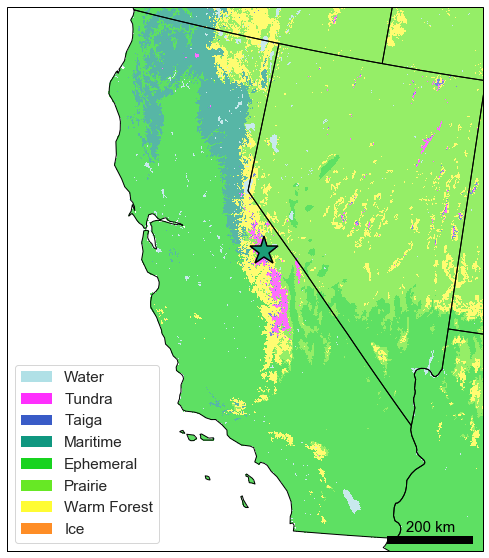

In [225]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795))

img = src.read(masked=True).squeeze()

extent = plot.plotting_extent(src)
view_extent = [-125.1, -103, 31, 49]
view_extent=CA_bbox
ax.set_extent(view_extent, crs=ccrs.PlateCarree())
ax.imshow(img, origin='upper', extent=extent, transform=ccrs.PlateCarree(), interpolation='nearest', cmap=sturm_cmap, alpha=0.7, vmin=0, vmax=8)

legend_handles = [
    patches.Patch(facecolor=color, edgecolor='none', label=label)
    for color, label in sturm_colors
]

states = cfeature.shapereader.Reader("/Users/tony/Downloads/ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.shp")
for record, state in zip(states.records(), states.geometries()):
    if record.attributes['adm0_a3'] == 'USA':
        ax.add_geometries([state], ccrs.PlateCarree(), facecolor='none', edgecolor='black')
        
# COLORADO
ax.plot(CO_XY[0], CO_XY[1], transform=ccrs.PlateCarree(), marker='*', markersize=30, color=CO_color, markeredgecolor='black', markeredgewidth=1.5)
# TUOLUMNE

ax.plot(CA_XY[0], CA_XY[1], transform=ccrs.PlateCarree(), marker='*', markersize=30, color=CA_color, markeredgecolor='black', markeredgewidth=1.5)
ax.legend(handles=legend_handles, loc='lower left')
scalebar.scale_bar(ax, (0.8, 0.02), 200, linewidth=8, text_offset=0.009, plot_kwargs={"solid_capstyle": 'butt'}, text_kwargs={'fontsize': 15})


# ax.gridlines(draw_labels=True)

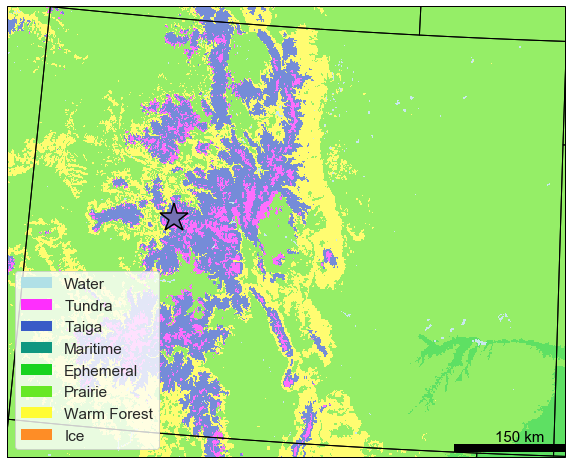

In [227]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795))
plot_sturm(src, CO_bbox, ax, scalebar_km=150)

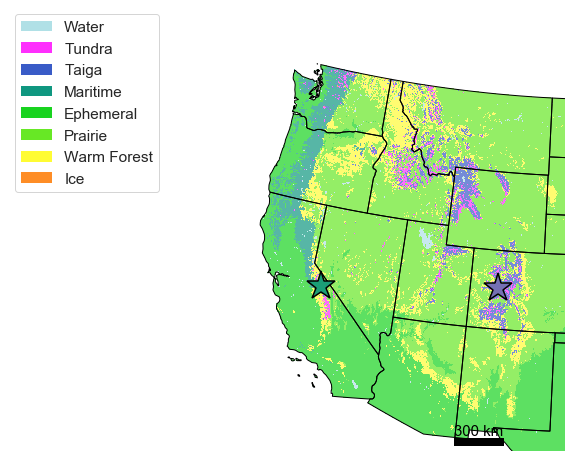

In [357]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795), frameon=False)
plot_sturm(src, CONUS_WEST_bbox, ax, scalebar_km=300, legend_loc='upper left')
ax.patch.set_alpha(0)
ax.outline_patch.set_visible(False)
ax.background_patch.set_facecolor('none')
plt.savefig("sturm_conus.png", dpi=300, transparent=True, bbox_inches='tight')

In [55]:
plot.plotting_extent(src)

(-124.7333355435, -66.9000045235, 24.549995418500004, 49.36666109250001)

## All

In [306]:
# plot config:
individual_states = False
focusers = True

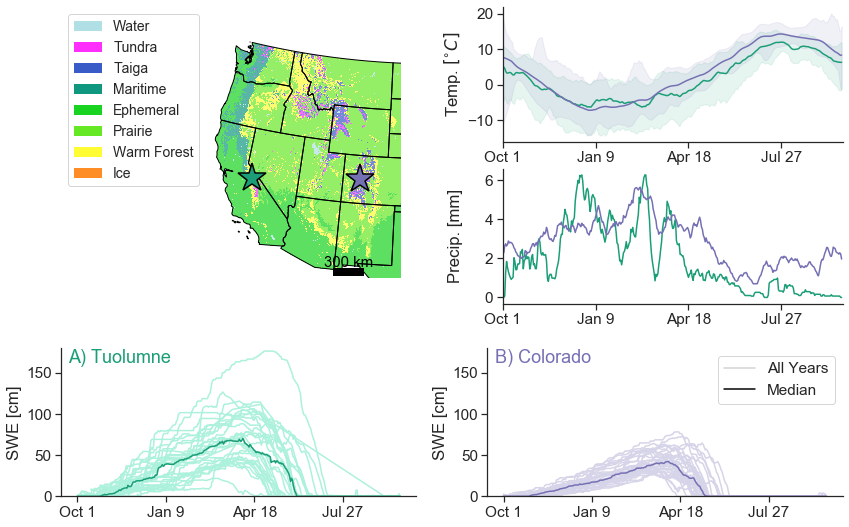

In [355]:
combined_fig = plt.figure(figsize=(14, 9))

main_gs = combined_fig.add_gridspec(2, 1, height_ratios=[2,1])

## Maps + Temp/Precip Climatology: 
if individual_states:
    top_half_gs = main_gs[0].subgridspec(2, 4, width_ratios = [1,1,1,2], wspace=0.2)
else:
    top_half_gs = main_gs[0].subgridspec(2, 2, width_ratios = [1,1], wspace=0.3)

# sturm_legend = combined_fig.add_subplot(top_half_gs[:, 0])
# legend_handles = [
#     patches.Patch(facecolor=color, edgecolor='none', label=label)
#     for color, label in sturm_colors
# ]
# sturm_legend.legend(handles=legend_handles, loc='center', prop={'size': 6})
# sturm_legend.axis('off')

if individual_states:
    map_ca = combined_fig.add_subplot(top_half_gs[:, 1],projection=ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795))
    plot_sturm(src, CA_bbox, map_ca, legend=False, scalebar_km=150)
    map_ca.outline_patch.set_visible(False)
    map_ca.patch.set_visible(False)
    map_ca.patch.set_alpha(0)


    map_co = combined_fig.add_subplot(top_half_gs[:, 2], projection=ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795))
    plot_sturm(src, CO_bbox, map_co, legend=False, scalebar_km=300)
    map_co.outline_patch.set_visible(False)
    map_co.patch.set_visible(False)
    map_co.patch.set_alpha(0)

else: 
    map_conus_west = combined_fig.add_subplot(top_half_gs[:, 0], projection=ccrs.AlbersEqualArea(central_latitude=39.8282, central_longitude=-98.5795), anchor='NW', xmargin=-0.4, aspect='equal')
    plot_sturm(src, CONUS_WEST_bbox, map_conus_west, scalebar_km=300, legend=True, legend_loc='upper left', legend_prop={'size': 14})
    map_conus_west.outline_patch.set_visible(False)
    map_conus_west.outline_patch.set_edgecolor('white')
    map_conus_west.axis('off')
    map_conus_west.background_patch.set_facecolor('none')
    map_conus_west.patch.set_visible(False)
    map_conus_west.patch.set_alpha(0)
    sns.despine(ax=map_conus_west)
    

## Sturm Underlying Focuser: 
# if focusers:
#     if individual_states:
#         sturm_rightmost = 3
#     else:
#         sturm_rightmost = 2
#     sturm_focus = combined_fig.add_subplot(top_half_gs[:, :sturm_rightmost], zorder=-1)
#     sturm_focus.tick_params(axis='both',which='both',bottom=0,left=0,
#                             labelbottom=0, labelleft=0)
#     sns.despine(left=True, bottom=True)
#     sturm_focus.set_facecolor('xkcd:salmon')
#     sturm_focus.patch.set_alpha(0.3)

### Plot Precipitation!!
if individual_states:
    rightmost_column = 3
else: 
    rightmost_column = 1
    
merged_precip = combined_fig.add_subplot(top_half_gs[1, rightmost_column])
plot_precip(dana_pcp_daily, "precip_m", merged_precip, color=CA_color)
plot_precip(co_precip, 'pcp_adjusted', merged_precip, color=CO_color)
merged_precip.set_xlim([0, 366])

locs, labels = merged_precip.get_xticks(), merged_precip.get_xticklabels()
merged_precip.xaxis.set_major_formatter(plt.FuncFormatter(format_doy))
sns.despine(ax=merged_precip)

# merged_precip.legend(handles=[
#     lines.Line2D([],[], color=CA_color, label=f'Tuolumne ({DANA_ELEVATION} m)')  ,
#     lines.Line2D([],[], color=CO_color, label=f'Colorado ({LOST_TRAIL_ELEVATION} m)')
# ], loc='lower left')

### Plot Temperature!
merged_temp = combined_fig.add_subplot(top_half_gs[0, rightmost_column], sharex = merged_precip)
# merged_temp.margins(0.05)
plot_temp(dana_temp_daily, 'T_deg_C', ax=merged_temp, color=CA_color)
plot_temp(co_tavg, "TAVG", ax=merged_temp, color=CO_color)
merged_temp.set_xlim([0, 366])
merged_temp.set_ylabel("Temp. $[^{\circ}C]$")
sns.despine(ax=merged_temp)

merged_precip.set_ylabel("Precip. [mm]")

combined_fig.align_labels([merged_precip, merged_temp])


bottom_half_gs = main_gs[1].subgridspec(1, 2)

tuolumne_swe = combined_fig.add_subplot(bottom_half_gs[0])
colorado_swe = combined_fig.add_subplot(bottom_half_gs[1])

dana_minyear = dana_snotel["Date"].min().year
dana_maxyear = dana_snotel["Date"].max().year
title=""
plot_snow(dana_snotel, "DanaSWE", title, tuolumne_swe, color=CA_color)

co_minyear = co_snotel.Date.min().year
co_maxyear = co_snotel.Date.max().year
# title = f"North Lost Trail SNOTEL, CO ({co_minyear}-{co_maxyear})"
title = ""
plot_snow(co_snotel, 'WTEQ', title, colorado_swe, color=CO_color)

colorado_swe.legend(handles=[
    lines.Line2D([], [], color='lightgray', label="All Years"),
    lines.Line2D([], [], color='black', label="Median")
], loc='upper right')

tuolumne_swe.text(0.02, .90, 'A) Tuolumne', fontsize=18, transform=tuolumne_swe.transAxes, color=CA_color)
colorado_swe.text(0.02, .90, 'B) Colorado', fontsize=18, transform=colorado_swe.transAxes, color=CO_color)


## Patches
# add_backbox(combined_fig, [tuolumne_swe, colorado_swe], color='xkcd:salmon', pad=0.01)
# add_backbox(combined_fig, [merged_temp, merged_precip], color='xkcd:denim', pad=0.01)


plt.savefig("site_climatology.pdf", dpi=300, bbox_inches='tight')
plt.savefig("site_climatology.png", dpi=300, bbox_inches='tight', transparent=True)